In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math


In [30]:
#Time Steps + Total Time
total_time = 30
time_steps = 1000
time_increment = total_time / time_steps

#Number of Nuclei + Total Number of Nuclear Spin States
nuclei_number = 4
total_spin_number = nuclei_number + 1 
Zi = 2**nuclei_number

#Hyperfine Coupling Constants 
a_ik = [-0.999985,-0.7369246,0.511210,-0.0826998,0.0655341,-0.562082,-0.905911,0.357729,0.358593,0.869386,-0.232996,0.0388327,0.661931,-0.930856,-0.893077,-0.0594001]

#Sympletic Integrator Constants
b_coefficients = np.array([0.1118965355841512,0.7035015731785551,-0.1465431690690314,0.3311450603063251])
a_coefficients = np.array([0.3311450603063251,-0.1465431690690314,0.7035015731785551,0.1118965355841512])

# Magnetic Field Strength
Mag_str = 0.5

# Gyromagnetic Ratio
gyro_ratio = -1.001

#Wi
wi = -gyro_ratio * Mag_str

# Define Spin Operators 
Sx = 0.5 * np.array([[0, 1], [1, 0]])  
Sy = 0.5 * np.array([[0, -1j], [1j, 0]])  
Sz = 0.5 * np.array([[1, 0], [0, -1]])  

Ikx = 0.5 * np.array([[0, 1], [1, 0]])  
Iky = 0.5 * np.array([[0, -1j], [1j, 0]])  
Ikz = 0.5 * np.array([[1, 0], [0, -1]]) 



In [31]:
def tensor_product_operator(spin_position, spin_operator):
    spin_array = [np.identity(2) for _ in range(nuclei_number)]
    spin_array[spin_position] = spin_operator
    S = spin_array[0]
    for i in range(1, nuclei_number):
        S = np.kron(S, spin_array[i])
    return S

def Hamiltonian():
    
    Hyperfine_interaction = np.zeros((2**total_spin_number, 2**total_spin_number), dtype=complex)

    Ikx_array = [None]*nuclei_number
    Iky_array = [None]*nuclei_number
    Ikz_array = [None]*nuclei_number

    for i in range(nuclei_number):
        Ikx_array[i] = tensor_product_operator(i,Ikx)
        Iky_array[i] = tensor_product_operator(i,Iky)
        Ikz_array[i] = tensor_product_operator(i,Ikz)

    Zeeman_interaction = wi*(np.kron(Ikz_array[0],np.identity(2)))

    for i in range(nuclei_number):
        Hyperfine_interaction += a_ik[i]*(np.kron(Sx,Ikx_array[i])+np.kron(Sy,Iky_array[i])+np.kron(Sz,Ikz_array[i]))
    
    return Zeeman_interaction + Hyperfine_interaction

    

def get_sigma_m(s_pins,n_spin): #Translate nuclei spin arrangement into vector of tensor products 
    combined_spins = (s_pins,) + n_spin

    vector_array = [None]*len(combined_spins)

    for i in range(total_spin_number): #Does not se
        if combined_spins[i] == 'up':
            vector_array[i] = [1,0]
        elif combined_spins[i] == 'down':
            vector_array[i] = [0,1]
        else:
            raise ValueError("Invalid spin state: must be 'up' or 'down'")

    tensor_product = vector_array[0]
    for j in range(1, len(vector_array)):
        tensor_product = np.kron(tensor_product,vector_array[j])
    return tensor_product

def possible_nuclei_spins():
    nuclei_spins = list(itertools.product(range(2), repeat=nuclei_number))
    mapped_spins = [tuple('up' if spin == 0 else 'down' for spin in arrangement) for arrangement in nuclei_spins]
    return mapped_spins

def calculate_energy(psi_t, Hi):
    psi_t_conj = np.conjugate(psi_t)
    H_psi_t = np.matmul(Hi,psi_t)
    energy = np.dot(psi_t_conj,H_psi_t)
    return energy 

def Sympletic_integrator(q_t, p_t,Hi):    
    p_list = { 'p_0': p_t }
    q_list = { 'q_0': q_t }
    
    for j in range(4):
        p_list['p_' + str(j+1)] =  p_list['p_' + str(j)] - (b_coefficients[j] * time_increment * np.dot(Hi, q_list['q_' + str(j)]))
        q_list['q_' + str(j+1)] =  q_list['q_' + str(j)] + (a_coefficients[j] * time_increment * np.dot(Hi, p_list['p_' + str(j+1)]))

    return q_list['q_4'], p_list['p_4']  

def Psi_t(q0,p0,Hi): 
    
    psi_t = [0] * time_steps
     #Initialise array 
    psi_t[0] = q0 + 1j * p0 

    q_t = q0
    p_t = p0

    for i in range(1, time_steps):
        q_t , p_t  = Sympletic_integrator(q_t, p_t, Hi)
        psi_t[i] = q_t + (1j * p_t)
  
    return psi_t

def exp_coeff(spins1,spins2,nspin1,nspin2,Hi): #Calculate the expansion coefficient spin1 = sigma M and spin2 = sigma' M'
    sigma_m_1 = get_sigma_m(spins1,nspin1)
    sigma_m_2 = get_sigma_m(spins2,nspin2)

    p0 = np.zeros_like(sigma_m_1)
    psi_t = Psi_t(sigma_m_1,p0,Hi)
    expansion_coefficient = np.zeros(time_steps, dtype=complex)

    for i in range(time_steps):
        expansion_coefficient[i] = np.dot(sigma_m_2,psi_t[i])
    return expansion_coefficient

def Calculate_R_xx_Rxy_R_zz():
    Hi = Hamiltonian()
    prefactor_R_xx_R_xy = 1/(2*Zi)
    prefactor_R_zz = 1/(4*Zi)
    nuclei_spins = possible_nuclei_spins()
    
    exp_coeff_sum_R_xx_R_xy = np.zeros(time_steps,dtype=complex)
    exp_coeff_sum_R_zz = np.zeros(time_steps,dtype=complex)

    for nspin1 in nuclei_spins: #M
        for nspin2 in nuclei_spins: #M'
            exp_coeff_up_up = exp_coeff('up','up',nspin1,nspin2,Hi) 
            exp_coeff_down_down = exp_coeff('down','down',nspin1,nspin2,Hi) 
            exp_coeff_down_up = exp_coeff('down','up',nspin1,nspin2,Hi)
            exp_coeff_up_down = exp_coeff('up','down',nspin1,nspin2,Hi)  
            for i in range(time_steps):
                exp_coeff_sum_R_xx_R_xy[i] += ((np.conjugate(exp_coeff_up_up[i])*exp_coeff_down_down[i]) + 
                                               (np.conjugate(exp_coeff_up_down[i])*exp_coeff_down_up[i])
                                               )
                exp_coeff_sum_R_zz[i] += ((np.conjugate(exp_coeff_up_up[i])*exp_coeff_up_up[i]) - 
                    (np.conjugate(exp_coeff_up_down[i])*exp_coeff_up_down[i]) - 
                    (np.conjugate(exp_coeff_down_up[i])*exp_coeff_down_up[i]) + 
                    (np.conjugate(exp_coeff_down_down[i])*exp_coeff_down_down[i]) 
                )
        
    R_xx_iR_xy = prefactor_R_xx_R_xy*exp_coeff_sum_R_xx_R_xy #will work if np.array 
    R_xx = np.real(R_xx_iR_xy)
    R_xy = np.imag(R_xx_iR_xy) # Something is inverting this graph minus should not be their 
    R_zz = np.real(prefactor_R_zz*exp_coeff_sum_R_zz)
    return R_xx, R_xy, R_zz


R_xx, R_xy, R_zz = Calculate_R_xx_Rxy_R_zz()


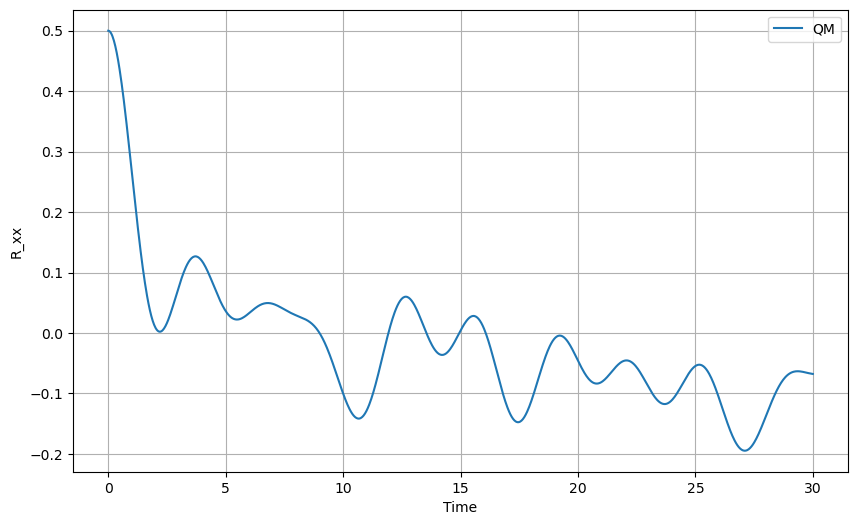

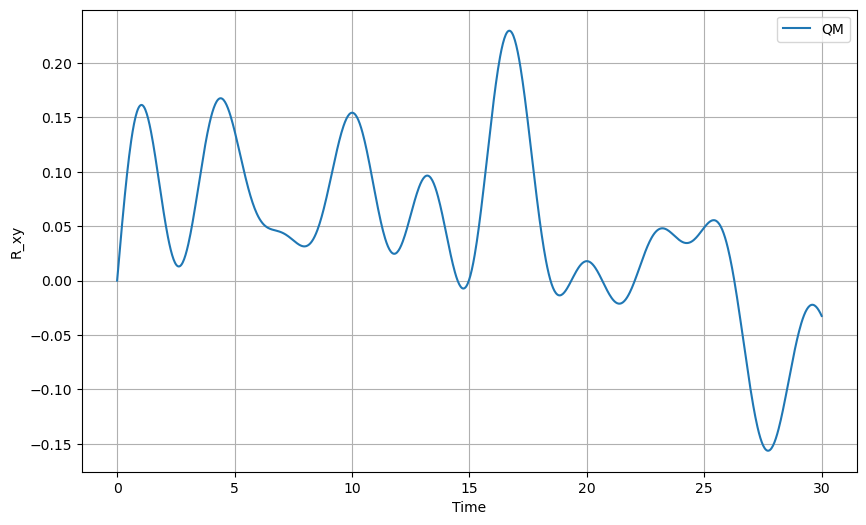

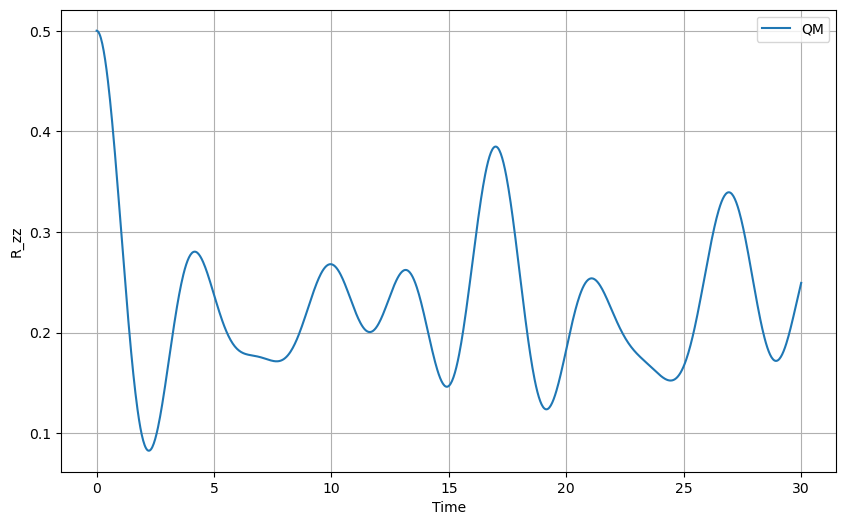

In [32]:
time_points = np.linspace(0, 30, time_steps)

plt.figure(figsize=(10, 6))
plt.plot(time_points, R_xx, label='QM')
plt.xlabel('Time')
plt.ylabel('R_xx')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_points, R_xy, label='QM')
plt.xlabel('Time')
plt.ylabel('R_xy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_points, R_zz, label='QM')
plt.xlabel('Time')
plt.ylabel('R_zz')
plt.legend()
plt.grid(True)
plt.show()
